# 2. Chart Types Using Seaborn

There exist many different ways to visualize the data and not every one of them is suitable for every dataset. Before you venture into creating beautiful visualizations, ask yourself: "What is it that I am really trying to show?". Only then you can find a plot type that best suits your needs. Of course, sometimes you just want to explore first - go ahead and try different chart types but keep in mind that even though some of them may be visually attractive, they do not necessarily convey the information in the best possible way.

Here, we will look at the basic types of plots and what kind of data they are good for. In this chapter, we will use the seaborn library to visualize (most) of them.

We will use the EMP dataset for this exercise - let's start by reading the data in:

###### Set up the envirnoment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from scipy import stats

data_dir = 'data/'

# this is to silence pandas' warnings
import warnings
warnings.simplefilter(action='ignore')
    
%matplotlib inline

#constant variables needed for the configuration of plots' appereance
FONT_SCALE = 1.3
FONT_FAMILY = 'DejaVu Sans'

In [2]:
def assign_elevation_level(x):
    """
    Assigns elevation profile based on 
    elevation in meters above sea level.
    """
    if x <= 500: 
        return 'low'
    elif 500 < x <= 1500:
        return 'medium'
    else:
        return 'high'

###### Loading the data

In [3]:
data = pd.read_csv(f'{data_dir}/emp500_meta.tsv', index_col=0, sep='\t')
data.shape

(730, 8)

In [4]:
data.iloc[:5, :3] # explore the first three columns of the first five records

,shannon_diversity,env_biome,env_package
sample_name,,,
13114.6.Mock.Community1,5.488934,urban biome,misc environment
13114.6.Mock.Community4,6.456336,urban biome,misc environment
13114.7.Mock.Community1,3.800636,urban biome,misc environment
13114.7.Mock.Community4,3.768911,urban biome,misc environment
13114.7.Mock.Community5,3.675092,urban biome,misc environment


Let's add one more column that will contain elevation profile of a sample, classified based on the actual elevation value (see the setup section to see what the assign_elevation_level actually does):

In [5]:
data['elevation_level'] = data['elevation'].astype(float).apply(assign_elevation_level)

As different types of plots operate on different types of data (numerical vs. categorical), we can briefly investigate which kind of data is present in which column of our dataset (keep in mind that if a column contains mixed data types or only strings it will be shown as `object` type):

In [6]:
data.dtypes

shannon_diversity    float64
env_biome             object
env_package           object
empo_4                object
empo_v2_4b            object
elevation            float64
ph                    object
water_content         object
elevation_level       object
dtype: object

## 2.1 Distribution 

As you already saw in at least one of the previous exercises (and probably know from other classes), often we are interested in learning about the distribution of the data before we do any kind of analysis. This can be achieved in several ways that are presented below.

**NOTE**: Most of the plots below were first generated using seaborn plotting functions and then customized slightly using matplotlib. Do not worry for now if you don't understand some of the matplotlib commands - we will look at them in more detail in [Chapter 3](matplotlib_manipulations.ipynb).

###### 2.1.1 Histogram

The most basic way to show an approximate distribution of numerical data where we divide the entire range of values into a series of intervals (bins) and then count how many values fall into each bin. We can also show the kernel density estimation (kde) which can smooth frequencies over the bins and show those as a continuous line.

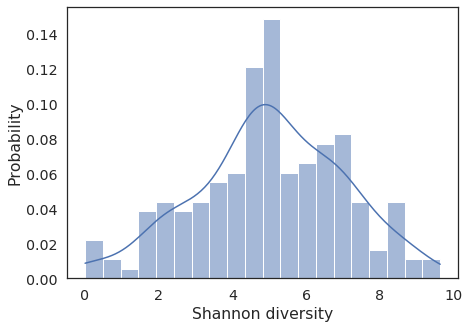

In [7]:
selection = data['env_biome'].isin(
    ('urban biome', 'desert biome', 'marine biome', 'forest biome', 'tundra biome')
)
subset = data.loc[selection, 'shannon_diversity']

sns.set(rc={'figure.figsize': (7, 5), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's histogram
    ax = sns.histplot(
        data=subset.tolist(), 
        kde=True,
        bins=20,
        stat='probability'
    )
    
    # matplotlib's customization
    ax.set_xlabel('Shannon diversity')

###### 2.1.2 Boxplot

A box plot can be used to represent the data distibution by visualizing its quartiles. Usually, it also contains whiskers which indicate variability of the data beyond the first and fourth quartile, and can contain individual points depicting outliers. You should always consult the documentation of the plotting library to make sure what the box plot exactly represents, as this may differ slightly between libraries and functions.

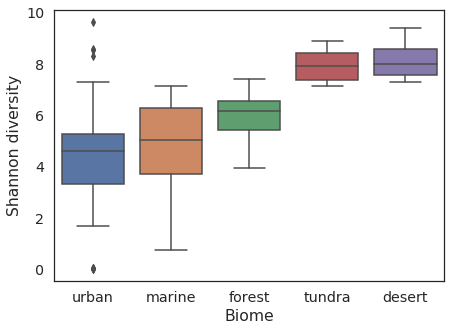

In [8]:
selection = data['env_biome'].isin(
    ('urban biome', 'desert biome', 'marine biome', 'forest biome', 'tundra biome')
)
subset = data.loc[selection, :]

sns.set(rc={'figure.figsize':(7, 5), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's boxplot
    ax = sns.boxplot(
        data=subset, 
        x='env_biome', 
        y='shannon_diversity'
    )
    
    # matplotlib's customization
    ax.set_xlabel('Biome')
    ax.set_ylabel('Shannon diversity')
    
    xlabels = ax.get_xticklabels()
    xlabels = [l.get_text().replace(' biome', '') for l in xlabels]
    ax.set_xticklabels(xlabels)

###### 2.1.3 Violin plot

A violin plot is very similar to a box plot with the addition of a kde. You can think of it as a box plot combined with a histogram: usually you can see the quartile features plus a smoothed frequency distribution.

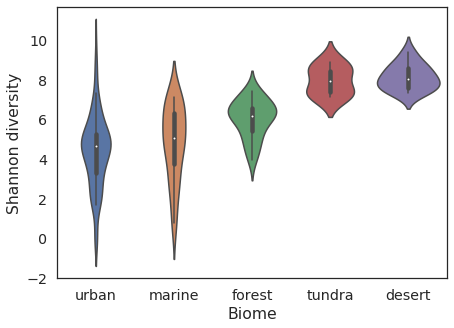

In [9]:
selection = data['env_biome'].isin(
    ('urban biome', 'desert biome', 'marine biome', 'forest biome', 'tundra biome')
)
subset = data.loc[selection, :]

sns.set(rc={'figure.figsize':(7, 5), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's violin plot
    ax = sns.violinplot(
        data=subset, 
        x='env_biome', 
        y='shannon_diversity', figsize=(20,20)
    )
    
    # matplotlib's customization
    ax.set_xlabel('Biome')
    ax.set_ylabel('Shannon diversity')
    
    xlabels = ax.get_xticklabels()
    xlabels = [l.get_text().replace(' biome', '') for l in xlabels]
    ax.set_xticklabels(xlabels)

###### 2.1.4 Ridgeline plot

A ridgeline plot, also know as Joyplot, shows the distribution of a numerical variable across many different groups. Distributions can be expressed using histograms or densitity plots, aligned to the same horizontal scale and presented with a slight overlap.

Here we will show the ridgeline plot of Shannon diversity for each of the selection groups.

In [10]:
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
      ha="left", va="center", transform=ax.transAxes)

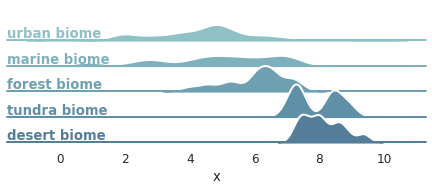

In [11]:
selection = data['env_biome'].isin(
    ('urban biome', 'desert biome', 'marine biome', 'forest biome', 'tundra biome')
)
subset = data.loc[selection, :].iloc[:, 0:2] #selecting the columns that we need
x = subset.iloc[:, 0]
g = subset.iloc[:, 1]
df = pd.DataFrame(dict(x=x, g=g))
    
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'font.family': [FONT_FAMILY]})
with sns.plotting_context("notebook", font_scale=1.1):
        #initialize the FacetGrid object
        pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

        #draw the densities in a few steps
        g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

        g.map(label, "x")

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

## 2.2 Relationship

There are several ways to visualize relationship between two (or more) variables. Most of the time, the scatter plot will be enough to show how two variables relate to one another. If a third variable is to be added to the picture, consider using a bubble plot or a heatmap rather than e.g. a 3D bar plot. 3D plots may work well as interactive visualizations but very often are not suitable for 2D prints/presentations as they can obscure parts of information.

###### 2.2.1 Scatter plot

In its most simple form, a scatter plot uses points to represent numerical values for a number of variables, where each variable is represented by an independent axis.

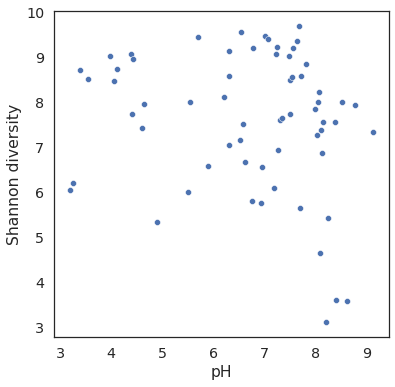

In [12]:
selection = (data['env_package'] == 'soil') & \
            data['ph'].notnull() & \
            (data['ph'] != 'not applicable') & \
            (data['ph'] != 'not provided')
subset = data.loc[selection, :]
subset['ph'] = subset['ph'].astype(float)

sns.set(rc={'figure.figsize':(6, 6), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        data=subset, 
        x='ph', 
        y='shannon_diversity'
    )
    
    # matplotlib's customization
    ax.set_xlabel('pH')
    ax.set_ylabel('Shannon diversity')

###### 2.2.2 Bubble plot

This is a slight modification of a scatter plot to add a third variable to the visualization without using a third axis (by doing which we would end up with a 3D plot). Instead, the scale of the third variable can be reflected by adjusting the size of individual points.

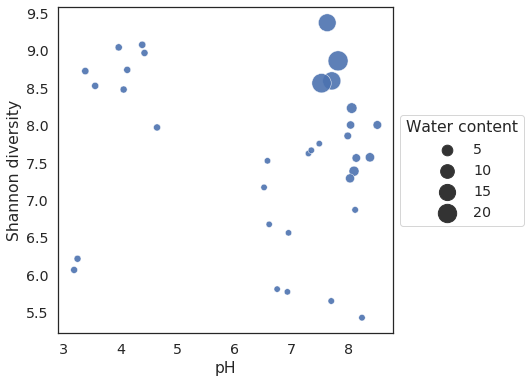

In [13]:
selection = (data['empo_v2_4b'].str.startswith('Soil')) & \
            data['ph'].notnull() & \
            (data['ph'] != 'not applicable') & \
            (data['ph'] != 'not provided') & \
            (data['water_content'] != 'not applicable')
subset = data.loc[selection, :]
subset['ph'] = subset['ph'].astype(float)
subset['water_content'] = subset['water_content'].astype(float)

sns.set(rc={'figure.figsize':(6, 6), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        x=subset['ph'], 
        y=subset['shannon_diversity'], 
        size=subset['water_content'],
        sizes=(40, 400),
        alpha=0.9
    )
    
    # matplotlib's customization
    ax.set_xlabel('pH')
    ax.set_ylabel('Shannon diversity')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend = ax.get_legend()
    legend.set_title('Water content')

###### 2.2.3 Heatmap

A heatmap is a visualization that can be used to represent magnitude of a phenomenon in two dimensions using a color scale. Below you can find two versions of a heatmap. The first one is a simple heatmap and the second one is an annotated heatmap.

In [14]:
selection = (data['env_package'] == 'soil')
subset = data.loc[selection, ['shannon_diversity', 'env_biome', 'elevation_level']]

subset_groups = subset.groupby(['env_biome', 'elevation_level']).mean().reset_index()

In [15]:
# we need to reshape the data sligthly before we can plot
subset_groups_pivot = subset_groups.pivot('env_biome', 'elevation_level', 'shannon_diversity')
subset_groups_pivot = subset_groups_pivot[['low', 'medium', 'high']]

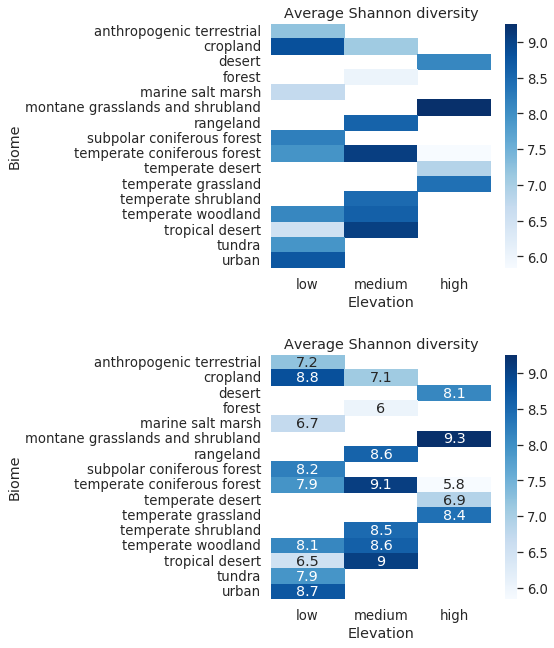

In [16]:
sns.set(rc={'figure.figsize':(6, 10), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
    plt.tight_layout(pad = 4)
    # seaborn's heatmap
    sns.heatmap(
        data=subset_groups_pivot,
        cmap='Blues',
        annot=False,
        ax = ax1
    )
    
    sns.heatmap(
        data=subset_groups_pivot,
        cmap='Blues',
        annot=True,
        ax = ax2
    )
    
    # matplotlib's customization
    ax1.set_xlabel('Elevation')
    ax1.set_ylabel('Biome')
    ax1.set_title('Average Shannon diversity')
    ax2.set_xlabel('Elevation')
    ax2.set_ylabel('Biome')
    ax2.set_title('Average Shannon diversity')
    
    
    ylabels = ax1.get_yticklabels()
    ylabels = [l.get_text().replace(' biome', '') for l in ylabels]
    ax1.set_yticklabels(ylabels)
    ax2.set_yticklabels(ylabels)
    plt.show()

###### 2.2.4 Correlogram

A correlogram or correlation matrix allows to analyse the relationship between each pair of **numeric** variables of a matrix. The correlation is visualised as a scatterplot. The diagonal represents the distribution of each variable with a histogram or a density plot.

In the seaborns `pairplot()` function you can specify the following parameters:

- `hue`: the variable that determines the groups in the data (this is mandatory)
- the **actual data** (this is mandatory)
- `markers`: list of  marker shapes
- `palette`: set of colors for mapping the `hue` variable

In the following example, we build the correlogram of Shannon diversity and elevation since they are the only numerical feature variables, for all the following biome groups: urban biome, desert biome, marine biome, forest biome, tundra biome.


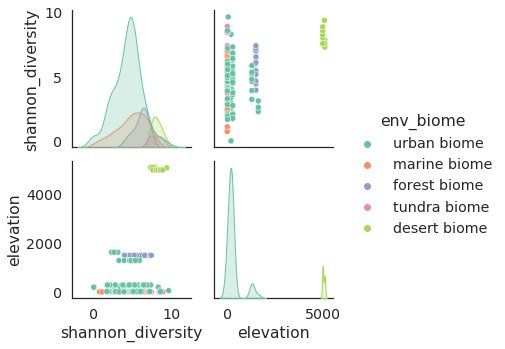

In [17]:
selection = data['env_biome'].isin(
    ('urban biome', 'desert biome', 'marine biome', 'forest biome', 'tundra biome')
)
subset = data.loc[selection, ['shannon_diversity', 'elevation', 'env_biome']]

sns.set(rc={'figure.figsize':(6, 8), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE): 
    sns.pairplot(subset, kind="scatter", hue="env_biome", palette="Set2")
    plt.show()

## 2.3 Composition

Often we may be interested in visualizing composition in our dataset. An example would be taxonomic composition of our samples. A pie chart is a visualization very often used for this type of data - unfortunately, rarely it is a good choice: human eye is not very good at reading angles. For this reason we will not consider this visualization below (instead, we can use e.g., stacked bar charts).

###### 2.3.1 Bar/Column Chart

A bar chart is a chart that presents categorical data with rectangular bars with heights or lengths proportional to the values that they represent. They can also represent aggregated metrics (e.g., mean of a variable - see below). The bars can be displayed vertically or horizontally.

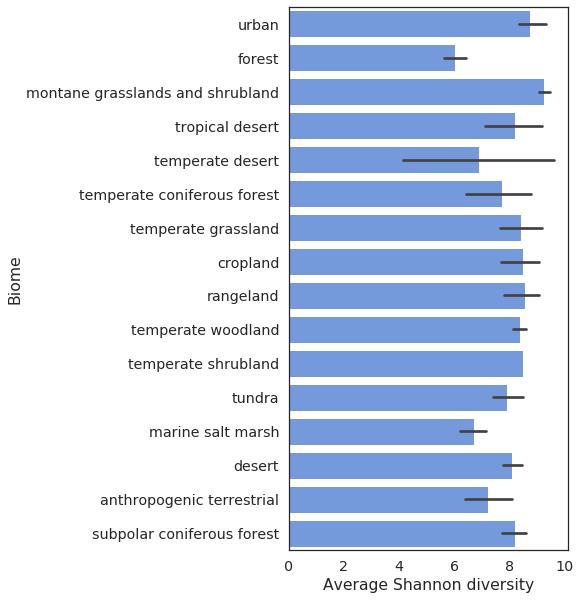

In [18]:
selection = (data['env_package'] == 'soil')
subset = data.loc[selection, :]

sns.set(rc={'figure.figsize':(5, 10), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # seaborn's bar plot
    ax = sns.barplot(
        data=subset,
        x='shannon_diversity',
        y='env_biome',
        orient='h',
        color='cornflowerblue'
    )
    
    # matplotlib's customization
    ax.set_xlabel('Average Shannon diversity')
    ax.set_ylabel('Biome')
    
    ylabels = ax.get_yticklabels()
    ylabels = [l.get_text().replace(' biome', '') for l in ylabels]
    ax.set_yticklabels(ylabels)

###### 2.3.2 Stacked bar/column plot

This is an extension of a simple bar chart to include numeric values from more than one variable. A set of distinct categorical values can be depicted as sub-bars that are stacked into a single bar, each one corresponding to a specific value of that second variable. Values can be plotted unnormalized (as they are in the data set; see the first plot below) or normalized (see the second plot below).

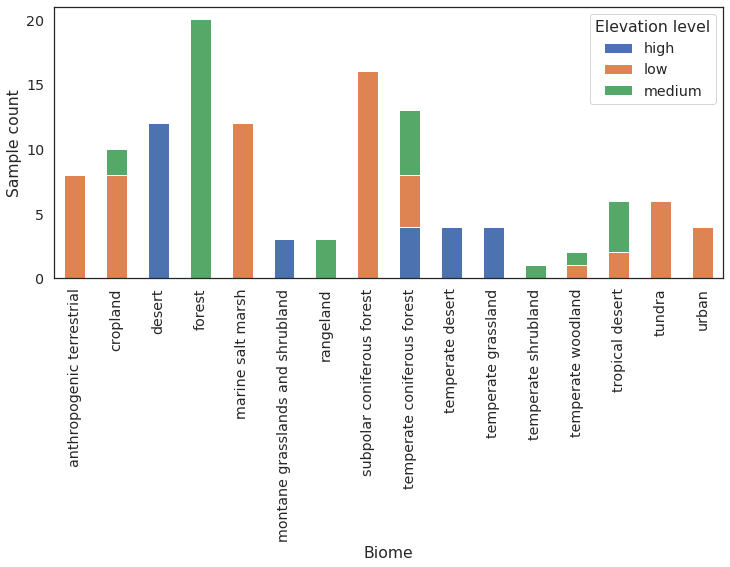

In [19]:
selection = (data['env_package'] == 'soil')
subset = data.loc[selection, ['shannon_diversity', 'env_biome', 'elevation_level']]

# we need to reshape the data sligthly before we can plot
stacked = subset.groupby(['env_biome', 'elevation_level']) \
                .count() \
                .reset_index() \
                .pivot('env_biome', 'elevation_level', 'shannon_diversity')

sns.set(rc={'figure.figsize':(12, 5), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # matplotlib's bar plot
    ax = stacked.plot(kind='bar', stacked=True)
    
    # matplotlib's customization
    ax.set_yticks(range(0, 21, 5))
    ax.set_xlabel('Biome')
    ax.set_ylabel('Sample count')
    legend = ax.get_legend()
    legend.set_title('Elevation level')
    
    xlabels = ax.get_xticklabels()
    xlabels = [l.get_text().replace(' biome', '') for l in xlabels]
    ax.set_xticklabels(xlabels)

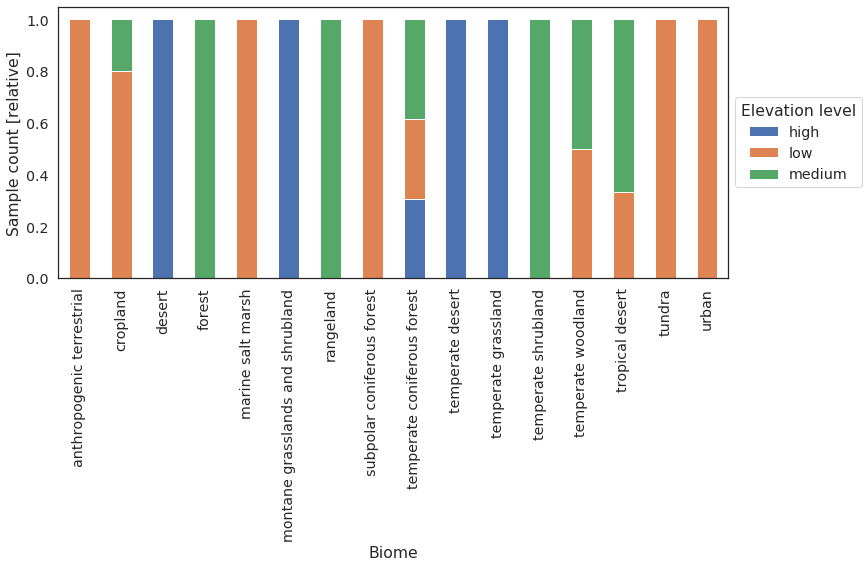

In [20]:
selection = (data['env_package'] == 'soil')
subset = data.loc[selection, ['shannon_diversity', 'env_biome', 'elevation_level']]

# we need to reshape the data sligthly before we can plot
stacked = subset.groupby(['env_biome', 'elevation_level']) \
                .count() \
                .reset_index() \
                .pivot('env_biome', 'elevation_level', 'shannon_diversity')
stacked_rel = stacked.div(stacked.sum(axis=1), axis=0)

sns.set(rc={'figure.figsize': (12, 5), 'font.family': [FONT_FAMILY]}, style='white')
with sns.plotting_context("notebook", font_scale=FONT_SCALE):
    # matplotlib's bar plot
    ax = stacked_rel.plot(kind='bar', stacked=True)
    
    # matplotlib's customization
    ax.set_xlabel('Biome')
    ax.set_ylabel('Sample count [relative]')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend = ax.get_legend()
    legend.set_title('Elevation level')
    
    xlabels = ax.get_xticklabels()
    xlabels = [l.get_text().replace(' biome', '') for l in xlabels]
    ax.set_xticklabels(xlabels)

###### 2.3.3 Tree Map

**NOTE:** In this section we use *plotly* instead of the *seaborn* library to generate the treemap. You can find more information on the [Plotly documentation](https://plotly.com/python/).

A Treemap displays hierarchical data as a set of nested rectangles. Each group is represented by a rectangle. The area of the recatngle's group is proportional to the value of the group for the particular numerical feature that is being visualized. Multiple groups and subgroups can be visualized by using different color schemes and interactivity.

Treemaps can show two types of information simultaneously:
- how the whole is divided: it helps in understanding which entities are the most and/or least important.
- how the hierarchy is organized: good for up to 3 levels of hierarchy otherwise things will get complicated.

Their biggest advantage is making the most efficient use of space and representing a lot of data as well. Tree Map can be made interactive to. This means that if we click on it we can expand and see the subgroups corresponding to group. More on this [here](https://www.data-to-viz.com/graph/treemap.html).

In [21]:
# Here we select only the columns that we need from the data table
df_selected = data[['env_biome', 'elevation_level']]
df_selected['number'] = range(1,len(data)+1) # add this column to be able to count the records

In [22]:
df_aggregated = df_selected.groupby(['elevation_level', 'env_biome'], as_index= False).count()

In [25]:
df = df_aggregated
fig = px.treemap(df_aggregated, path=['elevation_level', 'env_biome'], values='number',
                  color='number',
                  color_continuous_scale='redor',
                  color_continuous_midpoint=np.average(df_aggregated['number'], weights=df_aggregated['number']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In the next section we will see how we can customize plots using Matplotlib.